<a href="https://colab.research.google.com/github/sugiyama404/forecast_sp500/blob/main/forcast_sp500_lstm_gru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM,GRU

from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from google.colab import drive
import time

In [ ]:
drive.mount('/content/drive/')
nov_dir = 'Colab Notebooks/dataset/'  # このフォルダへのパス
nov_path = '/content/drive/My Drive/' + nov_dir + 'data_csv_sp500.csv'

df = pd.read_csv(nov_path)
df['Date'] = pd.to_datetime(df['Date'], format = '%Y-%m-%d')
df['SP500'] = preprocessing.scale(df['SP500'])

print(df.shape)

maxlen = 10
n_sample = len(df) - maxlen
X, Y = [], []
for i in range(len(df) - maxlen):
    X.append(df[['SP500']].iloc[i:(i+maxlen)].values)
    Y.append(df[['SP500']].iloc[i+maxlen].values)
X=np.array(X)
Y=np.array(Y)

print(X.shape)
print(Y.shape)

N_train = int(len(df) * 0.8)
N_test = len(df) - N_train
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=N_test, shuffle = False) 

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
(1768, 2)
(1758, 10, 1)
(1758, 1)


In [ ]:
def stopwatch(end_time,start_time):
  elapsed_time = int(end_time - start_time)

  elapsed_hour = elapsed_time // 3600
  elapsed_minute = (elapsed_time % 3600) // 60
  elapsed_second = (elapsed_time % 3600 % 60)

  mogi = str(elapsed_hour).zfill(2) + ":" + str(elapsed_minute).zfill(2) + ":" + str(elapsed_second).zfill(2)
  return mogi

In [ ]:
n_in = 1
n_mid = 20
n_out = 1
batch_size = 8
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

model_lstm = Sequential()
model_lstm.add(LSTM(n_mid,batch_input_shape=(None, maxlen, n_in),return_sequences=False))
model_lstm.add(Dense(n_in, kernel_initializer='random_uniform'))
model_lstm.add(Activation("linear"))
model_lstm.compile(loss = "mean_squared_error", optimizer=opt)
print(model_lstm.summary())

model_gru = Sequential()
model_gru.add(GRU(n_mid,batch_input_shape=(None, maxlen, n_in),return_sequences=False))
model_gru.add(Dense(n_in, kernel_initializer='random_uniform'))
model_gru.add(Activation("linear"))
model_gru.compile(loss = "mean_squared_error", optimizer=opt)
print(model_gru.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20)                1760      
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 20)                1380      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
___________________________

In [ ]:
epochs = 100

start_time = time.time()
hist_lstm = model_lstm.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,verbose=0)
print("学習時間 --LSTM--:", stopwatch(time.time(),start_time))

start_time = time.time()
hist_gru = model_gru.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,verbose=0)
print("学習時間 --GRU--:", stopwatch(time.time(),start_time))

学習時間 --LSTM--: 00:00:58
学習時間 --GRU--: 00:01:05


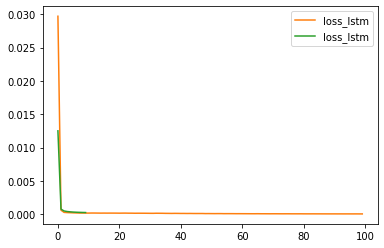

<Figure size 432x288 with 0 Axes>

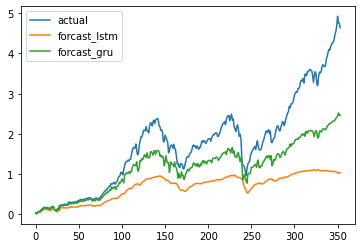

In [ ]:
nov_dir2 = 'Colab Notebooks/workspace/export/'

#　損失関数
loss_lstm = hist_lstm.history['loss']
epochs_lstm = len(loss_lstm)

loss_gru = hist_gru.history['loss']
epochs_gru = len(loss_gru)

plt.plot(range(epochs_lstm), loss_lstm, label="loss_lstm", color='tab:orange')
plt.plot(range(epochs_gru), loss_gru, label="loss_lstm", color='tab:green')
plt.legend()
nov_path = '/content/drive/My Drive/' + nov_dir2 + 'ex_fc1_3.png'

plt.savefig(nov_path)
plt.show()
plt.close('all')

# 予測結果
predicted_gru = model_gru.predict(X_test)
predicted_lstm = model_lstm.predict(X_test)
result = pd.DataFrame(predicted_gru)
result.columns = ['forcast_gru']
result['actual'] = y_test
result['forcast_lstm'] = predicted_lstm
result = result.reindex(columns=['actual', 'forcast_lstm', 'forcast_gru'])

plt.figure()
result.plot()
nov_path = '/content/drive/My Drive/' + nov_dir2 + 'ex_fc1_4.png'

plt.savefig(nov_path)
plt.show()
plt.close('all')


In [ ]:
n_in = 1
n_mid = 20
n_out = 1
batch_size = 1
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

model_gru2 = Sequential()
model_gru2.add(GRU(n_mid,batch_input_shape=(None, maxlen, n_in),return_sequences=True))
model_gru2.add(Dense(n_in, kernel_initializer='random_uniform'))
model_gru2.add(Activation("linear"))
model_gru2.compile(loss = "mean_squared_error", optimizer=opt)
print(model_gru.summary())

epochs = 10

start_time = time.time()
hist_gru = model_gru2.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,verbose=0)
print("学習時間 --GRU--:", stopwatch(time.time(),start_time))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 20)                1380      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 1,401
Trainable params: 1,401
Non-trainable params: 0
_________________________________________________________________
None
学習時間 --GRU--: 00:00:32


In [ ]:
# 学習済みモデル
n_rnn = maxlen
print(X.shape)
predicted = X[0].reshape(-1) #最初の入力、reshapeにより一次元にしてある。
print(predicted[-n_rnn:].reshape(batch_size, n_rnn, n_in).shape)

for i in range(0,n_sample):
  y = model_gru2.predict(predicted[-n_rnn:].reshape(batch_size, n_rnn, n_in))
  predicted = np.append(predicted, y[batch_size-1][n_rnn - 1][0])


print(predicted_gru.shape)
print("---------------")
print(predicted.shape)

(1758, 10, 1)
(1, 10, 1)
(354, 1)
---------------
(20,)
